In [35]:
import numpy as np
import random
from IPython.display import clear_output

class tictactoe:
    def __init__(self):
        """Board: 3x3 matrix ; 0 = Empty, 1 = Player (X), -1 = AI (O)"""
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1

    def reset(self):
        """Reset game for new episode"""   
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
        return self.get_state()
    
    def get_state(self):
        """Flatten 3x3 → 9-element vector for RL agent"""
        return self.board.flatten()
    
    def available_actions(self):
        """Legal moves only (empty cells)"""
        return [i for i in range(9) if self.board.flatten()[i] == 0]
    
    def step(self, action):
        """
        MAIN GAME LOGIC:
        Input: action (0-8)
        Output: next_state, reward, done
        """
        row, col = divmod(action, 3)

        #validate move
        if self.board [row, col]==0:
            self.board[row, col] = self.current_player
            self.current_player *= -1

            #check game end
            reward = self.check_winner()
            done = reward != 0 or len(self.available_actions()) == 0
            return self.get_state(), reward, done
        #invalid move , no change
        return self.get_state(), 0, False
    
    def check_winner(self):
        """Check rows, cols, diagonals for winner"""
        #rows
        for i in range(3):
            if (self.board[i,:]==1).all(): return 1 #player win
            if (self.board[i,:]==-1).all(): return -1 #ai win 

        #columns
        for i in range(3):
            if (self.board[:,i]==1).all(): return 1
            if (self.board[:,i]==-1).all(): return -1

        #diagonals
        if (np.diag(self.board) == 1).all(): return 1
        if (np.diag(self.board) == -1).all(): return -1
        if (np.diag(np.fliplr(self.board)) == 1).all(): return 1
        if (np.diag(np.fliplr(self.board)) == -1).all(): return -1     

        #draw or continue
        return 0 if len(self.available_actions()) > 0 else 0
    
#test environment
env = tictactoe()
state = env.reset()
print("Environment ready!")
print("Initial state:", state)



Environment ready!
Initial state: [0 0 0 0 0 0 0 0 0]


In [36]:
"""STEP 2: Q-LEARNING AGENT (Bellman Equation)
Q(s,a) ← Q(s,a) + α[R + γmaxQ(s',a') - Q(s,a)]
- α = learning rate (0.1)
- γ = discount factor (0.99) 
- ε-greedy exploration
"""
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.q_table = {}
        self.alpha = alpha #learning rate
        self.gamma = gamma #future reward discount
        self.epsilon = epsilon #exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def get_q(self, state, action):
        """Get Q-value or 0 if unseen"""
        return self.q_table.get((tuple(state), action), 0)
    def choose_action(self, state, available_actions):
        """
        ε-GREEDY POLICY:
        - ε% random (explore)
        - (1-ε)% best known (exploit)
        """
        if random.random() < self.epsilon:
            return random.choice(available_actions) #explore
        
        q_values = {a: self.get_q(state, a) for a in available_actions}
        return max(q_values, key=q_values.get) #exploit
    
    def update(self, state, action, reward, next_state, next_actions):
        """BELLMAN EQUATION UPDATE"""
        #best future action value
        best_next = max([self.get_q(next_state, a) for a in next_actions])if next_actions else 0
        #Q-value update
        old_q = self.get_q(state, action)
        new_q = old_q + self.alpha * (reward + self.gamma * best_next - old_q)
        self.q_table[(tuple(state), action)]= new_q

    def decay_epsilon(self): 
        """Gradually explore less"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("Q-Learning Agent ready!")
print("Starts 100% random ->Learn to win!")        


Q-Learning Agent ready!
Starts 100% random ->Learn to win!


In [37]:
"""STEP 3: TRAINING (1000 Games vs Itself)"""

def train_agent(episodes=1000):
    env = tictactoe()
    agent = QLearningAgent()
    rewards = [] # track learning progress

    print("Training started...")
    print("Episodes | Win Rate(last 100)")

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0

        # single episode
        while True:
            available = env.available_actions()
            if not available: #game over
                break

            #agent move
            action = agent.choose_action(state, available)
            next_state, reward, done = env.step(action)

            #learn from move
            next_available = env.available_actions()
            agent.update(state, action, reward, next_state, next_available)

            total_reward += reward
            state = next_state

            if done:
                break
        rewards.append(total_reward)
        agent.decay_epsilon()

        #progress display
        if ep % 200 == 0:
            win_rate = np.mean([r for r in rewards[-100:] if r == -1])
            print(f"{ep:4d} | {win_rate:.1%}")

    return agent, rewards

# Start Training
agent, rewards = train_agent(1000)
print("Training completed!")  
print(f"Final 100 games AI win rate: {np.mean([r for r in rewards[-100:] if r == -1]):.1%}")
print(f"Q-Table size: {len(agent.q_table):,}")      

Training started...
Episodes | Win Rate(last 100)
   0 | -100.0%
 200 | -100.0%
 400 | -100.0%
 600 | -100.0%
 800 | nan%
Training completed!
Final 100 games AI win rate: nan%
Q-Table size: 1,213


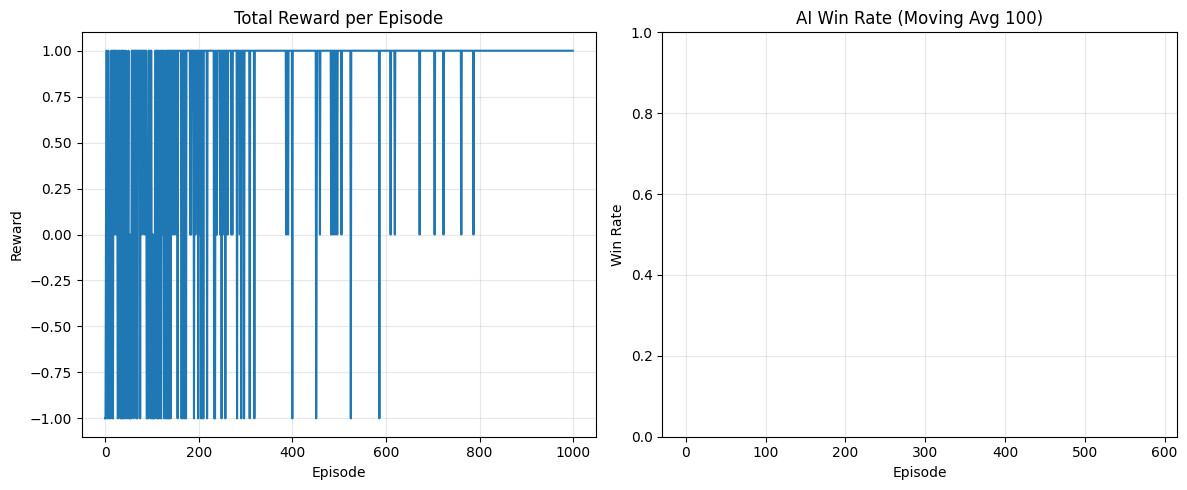

Learning curve saved!


In [38]:
"""STEP 4: PLOT LEARNING CURVE
Shows AI improvement over time!"""

import matplotlib.pyplot as plt

#calculate win rates
win_rates = []
for i in range(100, len(rewards)):
    recent = rewards[i-100:i]
    ai_wins = np.mean([r for r in recent if r == -1])
    win_rates.append(ai_wins)




plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(rewards)
plt.title('Total Reward per Episode')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.grid(True, alpha= 0.3)

#win rate
plt.subplot(1, 2, 2)
plt.plot(win_rates)
plt.title('AI Win Rate (Moving Avg 100)')
plt.ylabel('Win Rate')
plt.xlabel('Episode')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rl_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("Learning curve saved!")

In [39]:
"""STEP 5: PLAY AGAINST  AI!"""

def print_board(board):
    symbols = {1:'❌', -1:'⭕', 0:'🔹'}
    print("\n🎮 CURRENT BOARD:")
    for row in board:
        print(' | '.join(symbols[cell] for cell in row))
        print('─' * 9)

def play_vs_ai():
    env = tictactoe()
    state = env.reset()
    print("🎮 TIC-TAC-TOE vs RL AGENT!")
    print("🔢 Positions: 1|2|3 / 4|5|6 / 7|8|9")
    print("✅ Legal moves only!")


    while True:
        # YOUR TURN (X)
        print_board(env.board)
        available = env.available_actions()
        print(f"Available: {available}")
        
        try:
            move = int(input("\n❌ YOUR MOVE (1-9): ")) - 1
            if move in available:
                state, reward, done = env.step(move)
                winner = env.check_winner()
                if done:
                    print_board(env.board)
                    if winner == 1:
                        print("🎉 YOU WIN! 🏆")
                    elif winner == -1:
                        print("🤖 AI WINS! (Unbeatable!)")
                    else:
                        print("🤝 DRAW!")
                    break
            else:
                print("❌ Illegal move! Try again.")
        except:
            print("❌ Enter number 1-9!")



        # AI TURN (O)
        print("\n🤖 AI THINKING...")
        available = env.available_actions()
        if available:
            ai_move = agent.choose_action(state, available)
            state, reward, done = env.step(ai_move)
            winner = env.check_winner()
            if done:
                print_board(env.board)
                if winner == 1:
                    print("🎉 YOU WIN! 🏆")
                elif winner == -1:
                    print("🤖 AI WINS! (Unbeatable!)")
                else:
                    print("🤝 DRAW!")
                break    
